In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
%cd /content/drive/My Drive/Packages

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

%cd /content/drive/My Drive/GitHub/empire-migrations-coursework

/content/drive/My Drive/Packages
/content/drive/My Drive/GitHub/empire-migrations-coursework


In [40]:
projection = '+proj=aea +lat_1=50 +lat_2=70 +lat_0=56 +lon_0=100 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

In [136]:
regions = gpd.read_file('data/regions.geojson',
                        #crs = projection
                        )
data = pd.read_csv('data/interactions.csv')

# matplotlib maps

In [141]:
%cd /content/drive/My Drive/Packages

import matplotlib.pyplot as plt

%cd /content/drive/My Drive/GitHub/empire-migrations-coursework

/content/drive/My Drive/Packages
/content/drive/My Drive/GitHub/empire-migrations-coursework


In [142]:
params = {'figsize' : (15, 15), 
          'linewidth' : 0.5, 
          'edgecolor' : 'black', 
          'cmap' : 'Greens', 
          'missing_kwds' : {"color": "lightgrey", "label": "Missing values"},
          'legend' : True,
          'legend_kwds' : {'shrink': 0.5}
          }

In [157]:
def plot_variable(regions, var, plot_params={}, borders=True):
  params_base = plot_params.copy()
  del params_base['cmap']
  params_fig = plot_params.copy()
  del params_fig['missing_kwds']
  regions = regions.to_crs(projection)
  
  base = regions.plot(color = 'lightgrey', **params_base)
  fig = regions.plot(ax=base, column = var, **params_fig)

  if borders:
    fig.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
    plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
  else:
    fig.axis('off')

  return fig

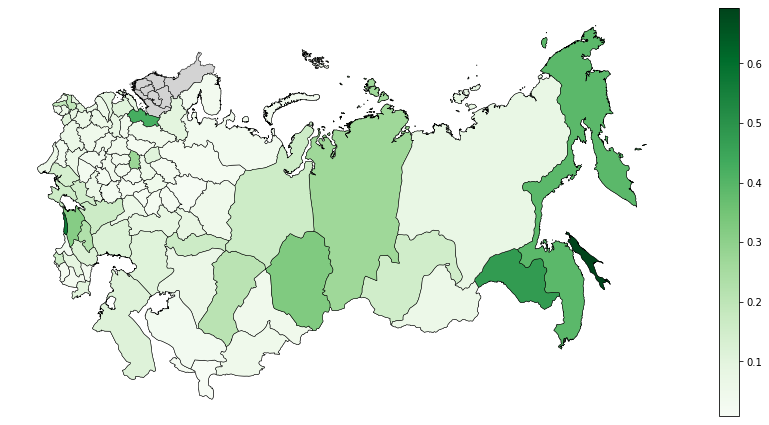

In [159]:
plot_variable(regions, 'mig_of_pop_to', params, borders=False)

In [160]:
def plot_region(df, regions, reg_name, how='to', plot_params = {}, borders=True):
  if how=='to':
      t='j'
      r='i'
  elif how=='from':
      t='i'
      r='j'
  else:
    raise ValueError

  regions = regions.to_crs(projection)

  df_reg = df.loc[df[f'name_{t}'] == reg_name]
  df_reg = regions[['geometry', 'name']].merge(df_reg, how='left', left_on=['name'], right_on=[f'name_{r}'])
  df_reg.crs = projection

  reg = df_reg[df_reg['name'] == reg_name]
  index = df_reg.index[df_reg['name'] == reg_name]
  df_reg = df_reg.drop(index, axis=0)
  
  main = df_reg.plot(column = 'mig_total', **plot_params)
  fig = reg.plot(ax = main, facecolor = "white", hatch = "///", linewidth = params['linewidth'], edgecolor = params['edgecolor'])

  if borders:
    fig.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
    plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
  else:
    fig.axis('off')

  return fig

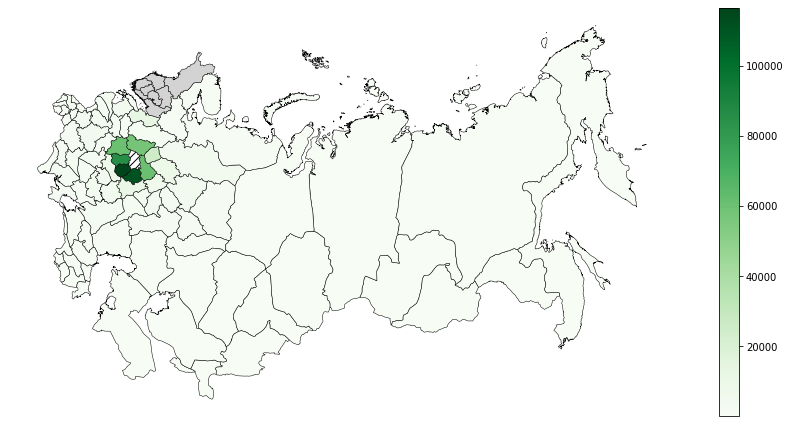

In [163]:
plot_region(data, regions, 'Московская губерния', how='to', plot_params=params)

# plotly-dash maps

In [ ]:
!pip install jupyter-dash -q

In [ ]:
!pip install -U plotly

In [ ]:
%cd /content/drive/My Drive/Packages

import plotly.express as px
#import json
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

%cd /content/drive/My Drive/GitHub/empire-migrations-coursework

In [126]:
def plot_variable(regions, var):
  missing = regions.loc[regions[color].isna(),:].fillna('No Data')

  missing_fig = px.choropleth(missing,
                              geojson=missing.geometry,
                              locations=missing.index,
                              color=var,
                              hover_name = 'name',
                              color_discrete_map={'No Data':'lightgrey'},
                              )
  
  fig = px.choropleth(regions,
                      geojson=regions.geometry,
                      locations=regions.index,
                      color=var,
                      hover_name = 'name',
                      color_continuous_scale='greens')
  fig.update_geos(visible=False, 
                  projection = dict(type = "conic equal area",
                                    parallels=[50,70]),
                  lonaxis_range=[28, 180],
                  lataxis_range=[44, 84],
                  showlakes=False,
                  )
  fig.update_layout(margin={"r":10,"t":10,"l":10,"b":10}, 
                    dragmode=False,
                    #legend=dict(orientation="h")
                    )
  
  fig.add_trace(missing_fig.data[0])
  fig.update_traces(showlegend=False)
  return fig

In [127]:
plot_variable(regions, 'lit_rate_total')

Output hidden; open in https://colab.research.google.com to view.

In [128]:
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("JupyterDash Demo"),
    html.Label([
        "color",
        dcc.Dropdown(
            id='color-dropdown', clearable=False,
            value='pop_total', options=[
                {'label': c, 'value': c}
                for c in [i for i in regions.columns.values if i not in ['name', 'name_eng', 'macroregion', 'geometry']]
            ])
    ]),
    dcc.Graph(id='graph',
              config={'displayModeBar': False}),
])

@app.callback(
    Output('graph', 'figure'),
    [Input("color-dropdown", "value")]
)
def update_figure(color):
    return plot_variable(regions, color)

app.run_server(mode='inline')

<IPython.core.display.Javascript object>

In [112]:
def plot_region(data, regions, reg_name, how):
  if how=='to':
      t='j'
      r='i'
  elif how=='from':
      t='i'
      r='j'
  else:
    raise ValueError
    
  df_reg = data.loc[data[f'name_{t}'] == reg_name]
  df_reg = regions[['geometry', 'name']].merge(df_reg, how='left', left_on=['name'], right_on=[f'name_{r}'])
  reg = df_reg[df_reg['name'] == reg_name]
  df_reg = df_reg.loc[df_reg['name'] != reg_name, :]

  self_fig = px.choropleth(reg,
                              geojson=reg.geometry,
                              locations=reg.index,
                              color='name',
                              hover_name='name',
                              color_discrete_map={reg_name:'grey'},
                              )

  fig = plot_variable(df_reg, 'mig_total')
  fig.add_trace(self_fig.data[0])
  fig.update_traces(showlegend=False)
  return fig

In [123]:
plot_region(data, regions, 'Томская губерния', how='from')

Output hidden; open in https://colab.research.google.com to view.

In [135]:
app = JupyterDash(__name__)
app.layout = html.Div([
  html.H1("JupyterDash Demo"),
  html.Div([
    html.Label("how"),
    dcc.Dropdown(
            id='how-dropdown', clearable=False,
            value='to', options=[
                {'label': c, 'value': c}
                for c in ['to', 'from']]),
    html.Label("region"),
    dcc.Dropdown(
            id='region-dropdown', clearable=False,
            value='Томская губерния', options=[
                {'label': c, 'value': c}
                for c in sorted(regions.name.unique())
            ]),
  ], style={'display': 'inline-block', 'vertical-align': 'top'}),
  html.Div([
    dcc.Graph(id='graph',
              config={'displayModeBar': False}),
            ], style={'display': 'inline-block', 'vertical-align': 'top'}),
])

@app.callback(
    Output('graph', 'figure'),
    [Input("region-dropdown", "value"),
     Input("how-dropdown", "value")]
)
def update_figure(region, how):
    return plot_region(data, regions, region, how)

app.run_server(mode='inline')

<IPython.core.display.Javascript object>